In [1]:
import pandas as pd
import numpy as np
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
from pyvi import ViPosTagger, ViTokenizer
from wordcloud import WordCloud 
import string
import matplotlib.pyplot as plt
import seaborn as sns

### Read the dataset

In [2]:
data = pd.read_csv('Products_Shopee_comments.csv')
data.head()

,product_id,category,sub_category,user,rating,comment
0,32,Điện Thoại & Phụ Kiện,Bảo vệ màn hình,sangth63,3,Miếng dán hơi dầy ko thẩm mỹ. Qan trong là ko ...
1,32,Điện Thoại & Phụ Kiện,Bảo vệ màn hình,truongthinga260787,3,"Mua nhiều miếng dán ở shop rồi, nhưng thật sự ..."
2,32,Điện Thoại & Phụ Kiện,Bảo vệ màn hình,n*****0,3,NaN
3,32,Điện Thoại & Phụ Kiện,Bảo vệ màn hình,hoanhq123,3,NaN
4,32,Điện Thoại & Phụ Kiện,Bảo vệ màn hình,vanguyen411,2,"Giao sai sp, đặt 1 cường lực trắng cho 8+ nhưn..."


In [3]:
data.category.value_counts()

Thời Trang Nam             1041870
Thời Trang Nữ               584108
Mẹ & Bé                     104958
Điện Thoại & Phụ Kiện        97403
Nhà Cửa & Đời Sống           18357
Thiết Bị Điện Tử             17129
Máy Tính & Laptop            14820
Máy Ảnh & Máy Quay Phim       5251
Sắc Đẹp                       1261
Name: category, dtype: int64

In [4]:
# Choose 'Thời Trang Nam'
data = data.loc[data['category'] == 'Thời Trang Nam']
data.head()

,product_id,category,sub_category,user,rating,comment
259179,0,Thời Trang Nam,Áo Ba Lỗ,karmakyun2nd,5,chưa ktra nên chưa biết đc đứa nào cũng đc như...
259180,0,Thời Trang Nam,Áo Ba Lỗ,tranquangvinh_vv,5,Lời đầu tiên cho phép được xin vì sự sơ suất c...
259181,0,Thời Trang Nam,Áo Ba Lỗ,nguyenquoctoan2005,5,1m6 50kg size M khá vừa vặn nhưng hok có cơ nê...
259182,0,Thời Trang Nam,Áo Ba Lỗ,nguyenthuyhavi,5,"Lần đầu mua shop, vải cũg khá ok. hợp vs mùa h..."
259183,0,Thời Trang Nam,Áo Ba Lỗ,luonganh5595,5,"áo đẹp form đẹp, mọi thứ đều ok, giao hàng nha..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041870 entries, 259179 to 1319048
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   product_id    1041870 non-null  int64 
 1   category      1041870 non-null  object
 2   sub_category  1041870 non-null  object
 3   user          1041870 non-null  object
 4   rating        1041870 non-null  int64 
 5   comment       537950 non-null   object
dtypes: int64(2), object(4)
memory usage: 55.6+ MB


In [6]:
data.shape

(1041870, 6)

### Data cleaning

In [7]:
# Check NaN values in 'comment' column
data['comment'].isnull().values.sum()

503920

In [8]:
# Drop NaN values
data = data.dropna().reset_index(drop=True)

In [9]:
data.shape

(537950, 6)

In [10]:
# Drop duplicated values
data = data.drop_duplicates()

In [11]:
data.shape

(530987, 6)

In [12]:
# Check how many reviews we have for each rating
data['rating'].value_counts().sort_index()

1     28653
2     15682
3     33861
4     59475
5    393316
Name: rating, dtype: int64

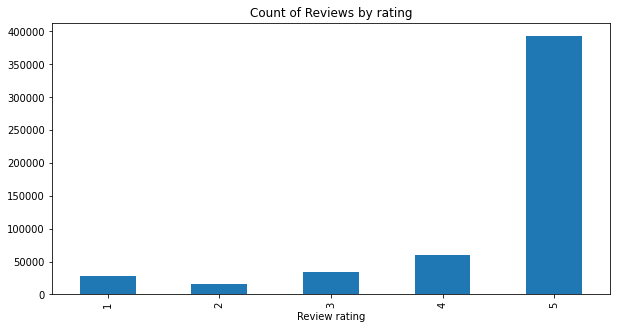

In [13]:
# Visualize count of reviews by rating
ax = data['rating'].value_counts().sort_index().plot(kind = 'bar',
                                                     title = 'Count of Reviews by rating',
                                                     figsize = (10, 5))
ax.set_xlabel('Review rating')
plt.show()

- Most of the reviews are 5 stars

### Pre-processing

In [14]:
##LOAD EMOJICON
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()
#################
#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [15]:
def process_text(text, emoji_dict, teen_dict, english_dict, wrong_lst):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### CONVERT ENGLISH
        sentence = ' '.join(english_dict[word] if word in english_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        ###### DEL wrong words   
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '                    
    document = new_sentence  
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [16]:
# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [17]:
# có thể bổ sung thêm các từ: chẳng, chả...
def process_special_word(text):
    new_text = ''
    text_lst = text.split()
    i= 0
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không' :
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [18]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

In [19]:
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [20]:
data['comment_pre'] = data['comment'].apply(lambda x: process_text(x, emoji_dict, teen_dict, english_dict, wrong_lst))

In [21]:
data['comment_pre'] = data['comment_pre'].apply(lambda x: convert_unicode(x))

In [22]:
data['comment_pre'] = data['comment_pre'].apply(lambda x: process_special_word(x))

In [23]:
data['comment_pre'] = data['comment_pre'].apply(lambda x: process_postag_thesea(x))

In [24]:
data['comment_pre'] = data['comment_pre'].apply(lambda x: remove_stopword(x, stopwords_lst))

In [25]:
data = data[['comment', 'comment_pre', 'rating']]

In [26]:
data.head()

,comment,comment_pre,rating
0,chưa ktra nên chưa biết đc đứa nào cũng đc như...,kiểm,5
1,Lời đầu tiên cho phép được xin vì sự sơ suất c...,cho_phép sơ_suất hát rõ_ràng,5
2,1m6 50kg size M khá vừa vặn nhưng hok có cơ nê...,vừa_vặn đỏ đỏ cổ đẹp nhức đẹp ổn,5
3,"Lần đầu mua shop, vải cũg khá ok. hợp vs mùa h...",đầu_shop hợp,5
4,"áo đẹp form đẹp, mọi thứ đều ok, giao hàng nha...",đẹp form đẹp hàng thích,5


In [27]:
def viz_wordcloud(rating, title):
    
    text = data[data['rating']==rating]['comment_pre'] 

    wordcloud = WordCloud(width=2000, 
                          height=1000, 
                          background_color='white', 
                          max_words=100).generate(' '.join(text))
    
    plt.figure(figsize=(10,8))
    plt.title(title, fontsize=15, weight='bold')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()

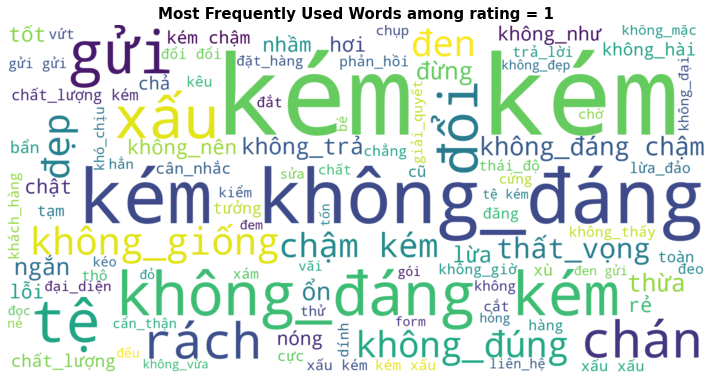

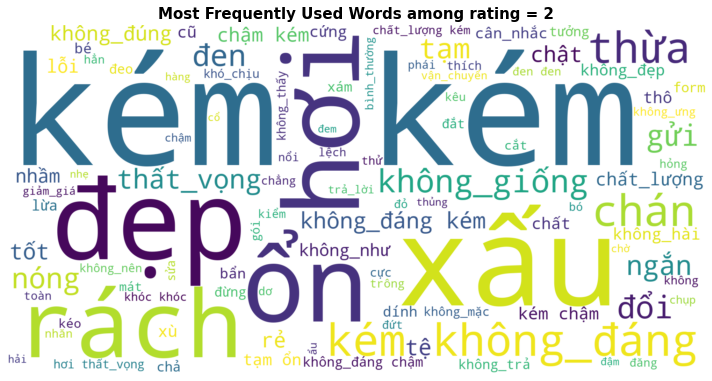

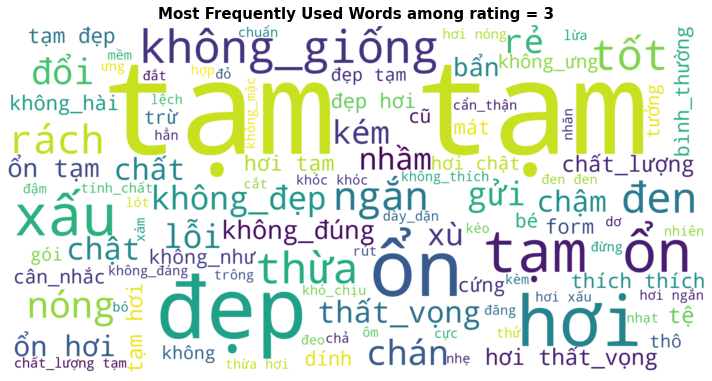

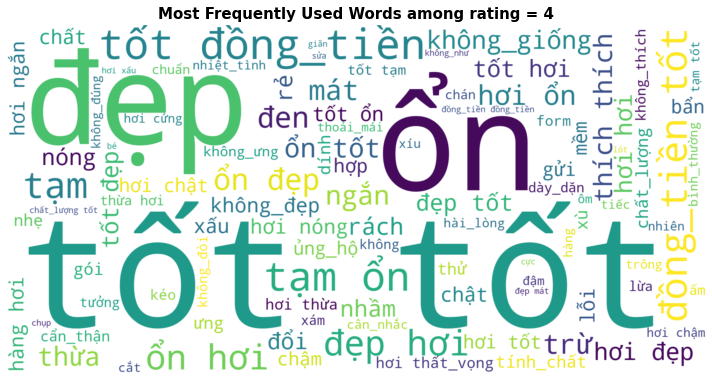

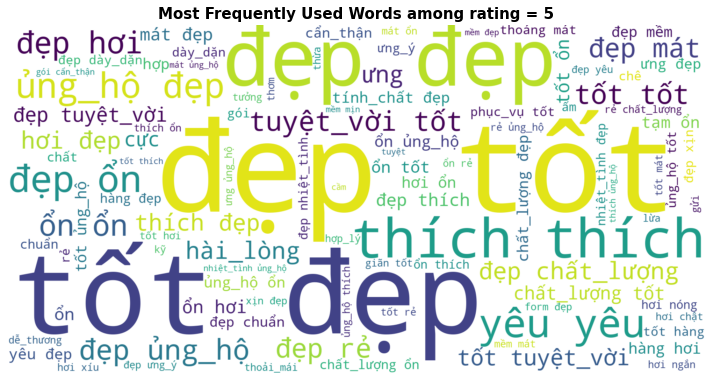

In [28]:
for i in range(1,6):
    viz_wordcloud(rating= i, title='Most Frequently Used Words among rating = %d' %i)

### Create a target variable

Rating 1 and 2 have similar frequently used words  
Rating 4 and 5 also have similar frequently used words  
Rating 3 has somewhat similar words with both rating 2 and 4   
=> I will divide rating into 3 which are:  
- 0: negative (rating = 1, 2)
- 1: neutral (rating = 3)
- 2: positive (rating = 4, 5)

In [29]:
data['target'] = pd.cut(data['rating'], bins=[0,2,3,5], labels=[0, 1, 2])

In [30]:
data.target.value_counts().sort_index()

0     44335
1     33861
2    452791
Name: target, dtype: int64

In [31]:
data.head()

,comment,comment_pre,rating,target
0,chưa ktra nên chưa biết đc đứa nào cũng đc như...,kiểm,5,2
1,Lời đầu tiên cho phép được xin vì sự sơ suất c...,cho_phép sơ_suất hát rõ_ràng,5,2
2,1m6 50kg size M khá vừa vặn nhưng hok có cơ nê...,vừa_vặn đỏ đỏ cổ đẹp nhức đẹp ổn,5,2
3,"Lần đầu mua shop, vải cũg khá ok. hợp vs mùa h...",đầu_shop hợp,5,2
4,"áo đẹp form đẹp, mọi thứ đều ok, giao hàng nha...",đẹp form đẹp hàng thích,5,2


In [32]:
def viz_wordcloud(target, title):
    
    text = data[data['target']==target]['comment_pre'] 

    wordcloud = WordCloud(width=2000, 
                          height=1000, 
                          background_color='white', 
                          max_words=100).generate(' '.join(text))
    
    plt.figure(figsize=(10,8))
    plt.title(title, fontsize=15, weight='bold')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()

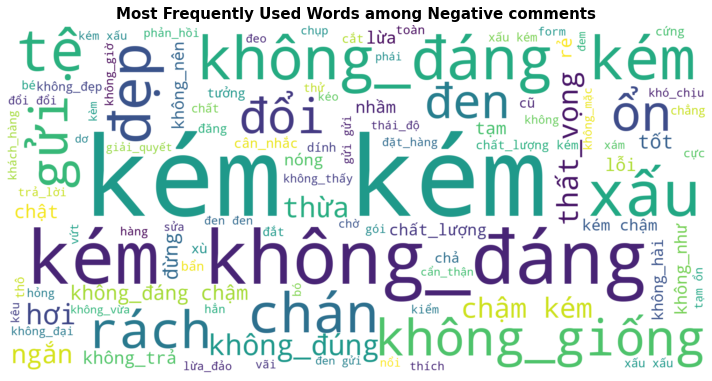

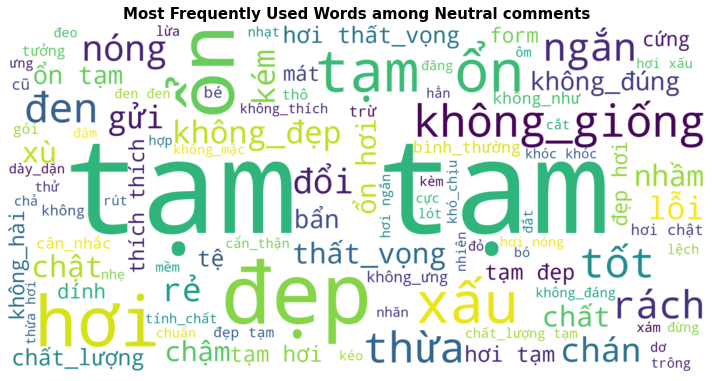

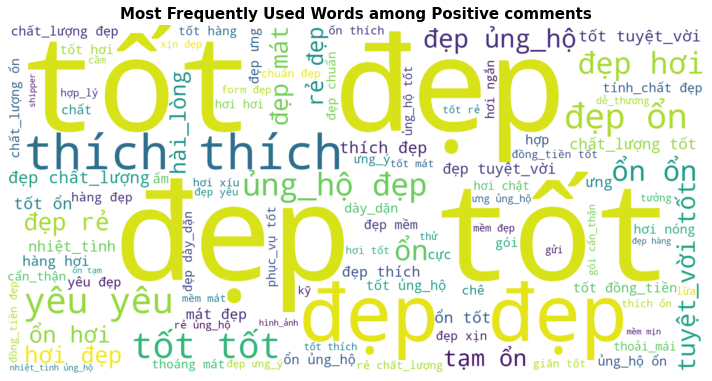

In [33]:
lst = ['Negative', 'Neutral', 'Positive']
for idx, sentiment in enumerate(lst):
    viz_wordcloud(target = idx, title='Most Frequently Used Words among %s comments' %sentiment)

- Most Frequently Used Words among negative comments are kém, xấu, không đáng, thất vọng,...
- Most Frequently Used Words among neutral comments are ổn, tạm, ...
- Most Frequently Used Words among positive comments are đẹp, tốt, tuyệt vời, hài lòng,...

In [34]:
# Check length of original comments
data['length'] = data['comment'].map(lambda x: len(x))

In [35]:
data.head()

,comment,comment_pre,rating,target,length
0,chưa ktra nên chưa biết đc đứa nào cũng đc như...,kiểm,5,2,65
1,Lời đầu tiên cho phép được xin vì sự sơ suất c...,cho_phép sơ_suất hát rõ_ràng,5,2,133
2,1m6 50kg size M khá vừa vặn nhưng hok có cơ nê...,vừa_vặn đỏ đỏ cổ đẹp nhức đẹp ổn,5,2,194
3,"Lần đầu mua shop, vải cũg khá ok. hợp vs mùa h...",đầu_shop hợp,5,2,64
4,"áo đẹp form đẹp, mọi thứ đều ok, giao hàng nha...",đẹp form đẹp hàng thích,5,2,73


In [36]:
target_length = data.groupby('target').mean('length')
target_length

,rating,length
target,,
0,1.353716,73.969843
1,3.000000,67.944833
2,4.868648,80.297625


- The length of positive comments are longer than neutral and negative commments

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530987 entries, 0 to 537949
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   comment      530987 non-null  object  
 1   comment_pre  530987 non-null  object  
 2   rating       530987 non-null  int64   
 3   target       530987 non-null  category
 4   length       530987 non-null  int64   
dtypes: category(1), int64(2), object(2)
memory usage: 20.8+ MB


In [38]:
data = data[['comment', 'comment_pre', 'target']]

In [39]:
data.head()

,comment,comment_pre,target
0,chưa ktra nên chưa biết đc đứa nào cũng đc như...,kiểm,2
1,Lời đầu tiên cho phép được xin vì sự sơ suất c...,cho_phép sơ_suất hát rõ_ràng,2
2,1m6 50kg size M khá vừa vặn nhưng hok có cơ nê...,vừa_vặn đỏ đỏ cổ đẹp nhức đẹp ổn,2
3,"Lần đầu mua shop, vải cũg khá ok. hợp vs mùa h...",đầu_shop hợp,2
4,"áo đẹp form đẹp, mọi thứ đều ok, giao hàng nha...",đẹp form đẹp hàng thích,2


In [40]:
data.to_csv('Data_pre.csv')